# Mount the Google Drive storage

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#  Install the required libraries

In [2]:
!pip install git+https://github.com/fastai/fastai 
!pip install git+https://github.com/fastai/fastcore

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-zosr__ck
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-zosr__ck
     |████████████████████████████████| 61kB 5.1MB/s 
  Created wheel for fastai: filename=fastai-2.2.4-cp36-none-any.whl size=190066 sha256=c188804b2e34d500b5b30a4ece3aa5ad149c022971ce41214674a9f5cbef3d22
  Stored in directory: /tmp/pip-ephem-wheel-cache-hwcmnomi/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-n_y14unq
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-n_y14unq
  Created wheel for fastcore: filename=fastcore-1.3.20-cp36-none-any.whl size=51776 sha256=593e7b0410c0ddcf19b1e45acc6e52dbd023e202be365dbab79ba0a1334bb820
  Stored in directory: /tmp/

## Setup the fastbook

In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.8MB/s 
     |████████████████████████████████| 1.2MB 48.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 


# Move to the working directory

In [4]:
!pwd

/content


In [5]:
%cd "/content/gdrive/MyDrive"

/content/gdrive/MyDrive


In [6]:
!pwd

/content/gdrive/MyDrive


## Sync the files with fastai repo

In [7]:
!git pull

Already up to date.


In [8]:
# Importing libs
from fastbook import *

# Import the Computer Vision related libs
from fastai.vision.widgets import *

- The Image dataset consists of bees and wasps.
- The download link is [bees-vs-wasps](https://www.kaggle.com/jerzydziewierz/bee-vs-wasp)
- Download the images and put them in your drive folder:
```
/content/gdrive/MyDrive/images/
```

In [13]:
# Setting the categories and the file-paths
fly_types = "bee", "wasp"
path = Path("images/bee_vs_wasp")

In [14]:
# saving file-paths in variable fns:
fns = get_image_files(path)
fns

(#4596) [Path('images/bee_vs_wasp/bee/36310704561_680ebebf6b_n.jpg'),Path('images/bee_vs_wasp/bee/38514571975_68fd0ce74e_m.jpg'),Path('images/bee_vs_wasp/bee/4817182248_f0d7899826_m.jpg'),Path('images/bee_vs_wasp/bee/4880255764_d6b54aa4c4_m.jpg'),Path('images/bee_vs_wasp/bee/36979072280_0687a62b01_w.jpg'),Path('images/bee_vs_wasp/bee/4879642917_e3cdd31840_n.jpg'),Path('images/bee_vs_wasp/bee/4777728098_5a6c70a44f_m.jpg'),Path('images/bee_vs_wasp/bee/4681248749_805a0459e3_n.jpg'),Path('images/bee_vs_wasp/bee/36009801074_7c60184f0c_n.jpg'),Path('images/bee_vs_wasp/bee/4551971928_0c403c845d_n.jpg')...]

- check for corrupted files

In [15]:
corrupt_files = verify_images(fns)
corrupt_files

(#0) []

- remove corrupt files by unlinking them from the Path variable.

In [ ]:
corrupt_files.map(Path.unlink)

## Create datablock object

In [19]:
bee_wasp = DataBlock(
    # what are the data we are providing? we are giving
    # images and their category labels
    blocks = (ImageBlock, CategoryBlock),
    # how to retrieve the data: using get_image_files
    get_items = get_image_files,
    # how to split data for validation set: percentage of total obs:
    splitter = RandomSplitter(valid_pct=0.3, seed = 42),
    # How to identify the labels?
    get_y = parent_label,
    # transform_data = Resize all images to get uniform size and less useless data:
    item_tfms = Resize(128)
)

- Create the dataloader

In [20]:
dls = bee_wasp.dataloaders(path)

- check few images of validation batch

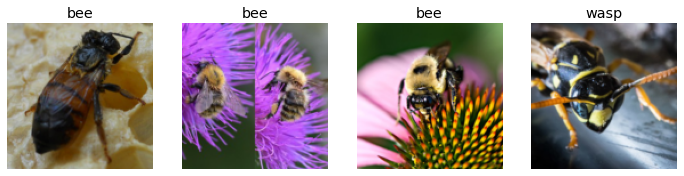

In [21]:
dls.valid.show_batch(max_n=4, nrows = 1)

## When we resize all images to same size , we loose some details , 
## to tackle this , we can use randomly cropped versions of same
## image to the model

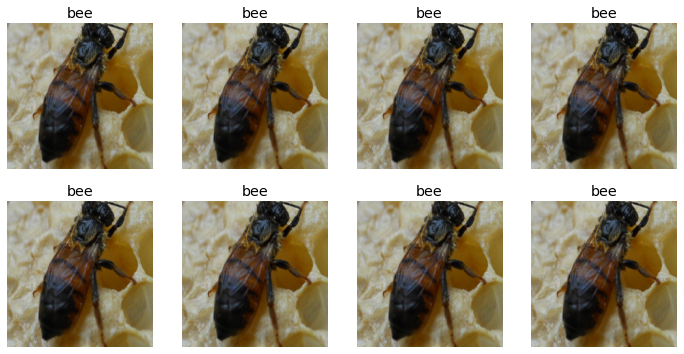

In [41]:
bee_wasp = bee_wasp.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.3)
)
dls = bee_wasp.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

## As all our images are of same size , we can apply batch transforms
## to save time using GPU.

In [39]:
bee_wasp = bee_wasp.new(
    item_tfms=RandomResizedCrop(size=224, min_scale=0.2), 
    # try changing min_scale
    batch_tfms=aug_transforms()
)
dls = bee_wasp.dataloaders(path)

In [42]:
# dls.valid.show_batch(max_n=12, nrows=3, unique=True)

# Training a CNN learner and fine-tuning it

In [43]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.472381,0.206651,0.064586,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.247612,0.187304,0.049347,00:23
1,0.204117,0.184186,0.050073,00:23
2,0.144044,0.173162,0.046444,00:23
3,0.107770,0.164954,0.047170,00:23


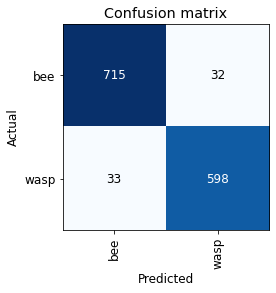

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [49]:
from google.colab import files
uploaded = files.upload()

Saving wasp2.jpg to wasp2.jpg


In [50]:
learn.predict(uploaded['wasp2.jpg'])

('wasp', tensor(1), tensor([3.3379e-05, 9.9997e-01]))

## Analyze the errors

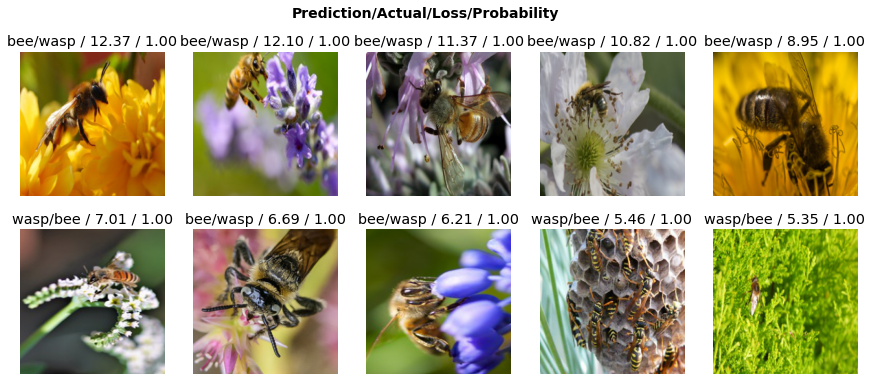

In [53]:
# get images with highest errors
interp.plot_top_losses(10, nrows=2)

- In the above images we can easily that the first images looks like a bee but
<br>wrongly labelled as wasp, we can see such mis-labelling in more images

### How to improve the model:
- Remove the mislabelled images 
- or change labels.